### TODO:
1) Start implementing the backend part.

In [48]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from skopt import BayesSearchCV
from skopt.space import Integer, Real

from xgboost import XGBRegressor


import matplotlib.pyplot as plt

### Necessary constants

In [2]:
# How many days we want to use to predict the next one
DEFAULT_DAYS_AMOUNT = 7

### In our case we will use S&P 500 index

In [2]:
# Set up a ticker
sp_500 = yf.Ticker(ticker='SPY')

In [3]:
sp_500.info

{'longBusinessSummary': 'The Trust seeks to achieve its investment objective by holding a portfolio of the common stocks that are included in the index (the “Portfolio”), with the weight of each stock in the Portfolio substantially corresponding to the weight of such stock in the index.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 573.76,
 'open': 573.4,
 'dayLow': 566.0,
 'dayHigh': 574.0622,
 'regularMarketPreviousClose': 573.76,
 'regularMarketOpen': 573.4,
 'regularMarketDayLow': 566.0,
 'regularMarketDayHigh': 574.0622,
 'trailingPE': 28.72101,
 'volume': 56341380,
 'regularMarketVolume': 56341380,
 'averageVolume': 51372314,
 'averageVolume10days': 54453000,
 'averageDailyVolume10Day': 54453000,
 'bid': 570.38,
 'ask': 570.44,
 'bidSize': 900,
 'askSize': 1200,
 'yield': 0.0121,
 'totalAssets': 566341992448,
 'fiftyTwoWeekLow': 409.21,
 'fiftyTwoWeekHigh': 574.71,
 'fiftyDayAverage': 552.3344,
 'twoHundredDayAverage': 522.4761,
 'trailingAnnualDividendRate': 5.662,
 'tr

In [94]:
# Define start date and end date
data_params = {
    'start': datetime(year=1980, month=1, day=1),
    'end': datetime(year=2024, month=9, day=1),
    'period': '1d'
}

In [95]:
# Get historical market data
data = sp_500.history(**data_params)

In [96]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,24.626124,24.626124,24.503606,24.608622,1003200,0.0,0.0,0.0
1993-02-01 00:00:00-05:00,24.626117,24.783640,24.626117,24.783640,480500,0.0,0.0,0.0
1993-02-02 00:00:00-05:00,24.766145,24.853658,24.713637,24.836155,201300,0.0,0.0,0.0
1993-02-03 00:00:00-05:00,24.871145,25.116181,24.853643,25.098679,529400,0.0,0.0,0.0
1993-02-04 00:00:00-05:00,25.186212,25.256222,24.906171,25.203714,531500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-08-26 00:00:00-04:00,561.457840,562.185589,557.340465,559.075134,35788600,0.0,0.0,0.0
2024-08-27 00:00:00-04:00,557.779157,560.341306,556.612752,559.842834,32693900,0.0,0.0,0.0
2024-08-28 00:00:00-04:00,559.493909,559.932566,553.342732,556.592773,41066000,0.0,0.0,0.0


In [97]:
# Check if there is any columns with one value only
excluded_cols = []
for col in data.columns.values:
    if len(data.loc[:, col].unique()) == 1:
        excluded_cols.append(col)
excluded_cols

['Stock Splits', 'Capital Gains']

In [98]:
# Check "Dividends" column
data.loc[:, 'Dividends'].value_counts()

Dividends
0.000    7827
0.348       3
0.719       2
0.352       2
0.351       2
         ... 
0.360       1
0.354       1
0.436       1
0.378       1
1.759       1
Name: count, Length: 120, dtype: int64

In [99]:
# Since the most values are zeros in "Dividends" add this column to the list of excluded columns
excluded_cols.append('Dividends')

In [100]:
# Remove the unnecessary columns
data = data.drop(labels=excluded_cols, axis=1)
data

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29 00:00:00-05:00,24.626124,24.626124,24.503606,24.608622,1003200
1993-02-01 00:00:00-05:00,24.626117,24.783640,24.626117,24.783640,480500
1993-02-02 00:00:00-05:00,24.766145,24.853658,24.713637,24.836155,201300
1993-02-03 00:00:00-05:00,24.871145,25.116181,24.853643,25.098679,529400
1993-02-04 00:00:00-05:00,25.186212,25.256222,24.906171,25.203714,531500
...,...,...,...,...,...
2024-08-26 00:00:00-04:00,561.457840,562.185589,557.340465,559.075134,35788600
2024-08-27 00:00:00-04:00,557.779157,560.341306,556.612752,559.842834,32693900
2024-08-28 00:00:00-04:00,559.493909,559.932566,553.342732,556.592773,41066000


In [101]:
# Save the dataset in ".csv" file
data.to_csv("s_p_500_data.csv")

In [3]:
data = pd.read_csv('s_p_500_data.csv')
data

,Date,Open,High,Low,Close,Volume
0,1993-01-29 00:00:00-05:00,24.626124,24.626124,24.503606,24.608622,1003200
1,1993-02-01 00:00:00-05:00,24.626117,24.783640,24.626117,24.783640,480500
2,1993-02-02 00:00:00-05:00,24.766145,24.853658,24.713637,24.836155,201300
3,1993-02-03 00:00:00-05:00,24.871145,25.116181,24.853643,25.098679,529400
4,1993-02-04 00:00:00-05:00,25.186212,25.256222,24.906171,25.203714,531500
...,...,...,...,...,...,...
7949,2024-08-26 00:00:00-04:00,561.457840,562.185589,557.340465,559.075134,35788600
7950,2024-08-27 00:00:00-04:00,557.779157,560.341306,556.612752,559.842834,32693900
7951,2024-08-28 00:00:00-04:00,559.493909,559.932566,553.342732,556.592773,41066000
7952,2024-08-29 00:00:00-04:00,558.596606,561.956296,555.476173,556.642578,38715200


### Split data into train, test, and out of time (OOT) sets

In [4]:
data['Date'] = pd.to_datetime(data.loc[:, 'Date'], utc=True)

In [5]:
data.dtypes

Date      datetime64[ns, UTC]
Open                  float64
High                  float64
Low                   float64
Close                 float64
Volume                  int64
dtype: object

In [25]:
# Get the main and OOT data (We will use only "Close" feature)
oot_threshold = '2020-01-01'
oot_data = data.loc[data.loc[:, 'Date'] >= oot_threshold, :]
oot_data.index = oot_data.loc[:, 'Date']
oot_data = oot_data.loc[:, ['Close']]

main_data = data.loc[data.loc[:, 'Date'] < oot_threshold, :]
main_data.index = main_data.loc[:, 'Date']
main_data = main_data.loc[:, ['Close']]

In [26]:
# Define a function to create a new dataset with multiple features
def shift_by_days(df: pd.DataFrame, shift_days_amount: int = DEFAULT_DAYS_AMOUNT) -> pd.DataFrame:
    handler_df = df.copy()
    
    handler_df['Close_-1'] = handler_df.loc[:, 'Close'].shift(1)
    for day_idx in range(2, shift_days_amount + 1):
        handler_df[f'Close_-{day_idx}'] = handler_df.loc[:, f'Close_-{day_idx - 1}'].shift(1)
    
    return handler_df.dropna()

In [27]:
main_data = shift_by_days(df=main_data, shift_days_amount=DEFAULT_DAYS_AMOUNT)
oot_data = shift_by_days(df=oot_data, shift_days_amount=DEFAULT_DAYS_AMOUNT)

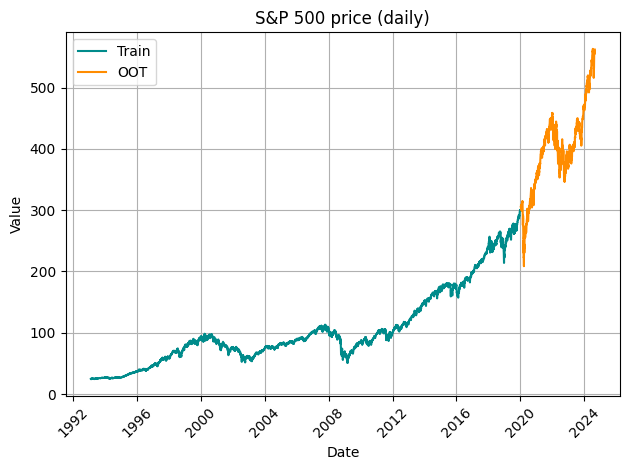

In [28]:
# Plot the data
plt.plot(main_data.index, main_data.loc[:, 'Close'].values, label='Train', color='darkcyan')

plt.plot(oot_data.index, oot_data.loc[:, 'Close'].values, label='OOT', color='darkorange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('S&P 500 price (daily)')

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

As we can see from the plot, the difference between OOT and main data is huge. That is why we can expect it to behave badly in OOT data (if we did not train it on OOT).

In [29]:
# Split the main data into train and test sets
X_train, X_test = train_test_split(main_data, test_size=0.3, random_state=42)

In [30]:
# Split all data into X and y
y_train = X_train.loc[:, 'Close']
X_train = X_train.drop(labels=['Close'], axis=1)

y_test = X_test.loc[:, 'Close']
X_test = X_test.drop(labels=['Close'], axis=1)

y_oot = oot_data.loc[:, 'Close']
X_oot = oot_data.drop(labels=['Close'], axis=1)

In [12]:
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"OOT shape: {X_oot.shape}")

Train shape: (4741, 7)
Test shape: (2032, 7)
OOT shape: (1167, 7)


### Model training

In [13]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Basic XGBRegressor performance of all sets of data
print(f"Train MSE: {mean_squared_error(y_train, model.predict(X_train))}")
print(f"Test MSE: {mean_squared_error(y_test, model.predict(X_test))}")
print(f"OOT MSE: {mean_squared_error(y_oot, model.predict(X_oot))}")

Train MSE: 0.606375521150725
Test MSE: 2.025791539795835
OOT MSE: 16152.590703681928


As it was stated above, on OOT the performance decreases badly.

### Model and preprocessing fine-tuning

In [188]:
# Define a parameters grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.1, 0.5, 1],
    'lambda': [1, 5, 10],
    'alpha': [0, 0.1, 1, 5]
}

In [189]:
# Define a GridSearchCV instance
search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [15]:
search_space = {
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'eta': Real(0.01, 0.3),
    'gamma': Real(0, 1),
    'lambda': Real(0, 10),
    'alpha': Real(0, 10)
}

In [18]:
# Iterate through the different amount of days and search for the best combination for each one
days_amount = [i for i in range(1, 8)]
scores = {}
for n in days_amount:
    train_data = shift_by_days(df=main_data, shift_days_amount=n)
    X_train, X_test = train_test_split(train_data, test_size=0.3, random_state=42)
    
    y_train = X_train.loc[:, 'Close']
    X_train = X_train.drop(labels=['Close'], axis=1)
    
    opt = BayesSearchCV(
        estimator=XGBRegressor(),
        search_spaces=search_space,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=0,
        n_jobs=-1
    )
    
    opt.fit(X_train, y_train)
    
    scores[f'n({n})'] = {'Score': opt.best_score_,
                         'Params': opt.best_params_}
    print(f'n({n}) passed. Best score: {opt.best_score_}')

n(1) passed. Best score: -1.9592720730295579
n(2) passed. Best score: -1.879664231706289
n(3) passed. Best score: -1.9155005066358115
n(4) passed. Best score: -1.8395551836202544
n(5) passed. Best score: -1.9030578789922292
n(6) passed. Best score: -1.8725029193296945
n(7) passed. Best score: -1.9322600919333184


### Select the best performing model and amount of days (shifted)

In [24]:
best_params = scores['n(4)']['Params']
n_days = 4
selected_model = XGBRegressor(**best_params)

In [31]:
# Split the main data into train and test sets
X_train, X_test = train_test_split(main_data, test_size=0.3, random_state=42)

# Split all data into X and y
y_train = X_train.loc[:, 'Close']
X_train = X_train.drop(labels=['Close'], axis=1)

y_test = X_test.loc[:, 'Close']
X_test = X_test.drop(labels=['Close'], axis=1)

y_oot = oot_data.loc[:, 'Close']
X_oot = oot_data.drop(labels=['Close'], axis=1)

In [32]:
selected_model.fit(X_train, y_train)

XGBRegressor(alpha=9.863587879677828, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8946785775181343, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.0854004625857391, eval_metric=None, feature_types=None,
             gamma=0.22805135988612135, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=2.100259903271974,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=9, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [33]:
# Basic XGBRegressor performance of all sets of data
print(f"Train MSE: {mean_squared_error(y_train, selected_model.predict(X_train))}")
print(f"Test MSE: {mean_squared_error(y_test, selected_model.predict(X_test))}")
print(f"OOT MSE: {mean_squared_error(y_oot, selected_model.predict(X_oot))}")

Train MSE: 1.3176724489284553
Test MSE: 1.8040345669757565
OOT MSE: 16365.32702805024


### Now, train the model on a whole dataset and save it

In [40]:
data_full = data.copy()
data_full.index = data_full.loc[:, 'Date']
data_full = data_full.loc[:, ['Close']]

data_full = shift_by_days(df=data_full, shift_days_amount=n_days)
y_full = data_full.loc[:, 'Close']
X_full = data_full.drop(labels=['Close'], axis=1)

In [43]:
final_model = XGBRegressor(**best_params)
final_model.fit(X_full, y_full)

XGBRegressor(alpha=9.863587879677828, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8946785775181343, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.0854004625857391, eval_metric=None, feature_types=None,
             gamma=0.22805135988612135, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=2.100259903271974,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=9, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [44]:
# Full dataset MSE
print(f"Full dataset MSE: {mean_squared_error(y_full, final_model.predict(X_full))}")

Full dataset MSE: 4.581071572952035


In [49]:
report_v1 = {
    'model': final_model,
    'n_days': n_days
}

In [52]:
# Save our model
with open('../models/xgbregressor_v1.pkl', 'wb') as file:
    pickle.dump(report_v1, file)

In [53]:
# Load the saved model
with open('../models/xgbregressor_v1.pkl', 'rb') as file:
    report_details = pickle.load(file)

loaded_model = report_details['model']